# 💈 Project 3: DMSP Particle Precipitate Flux Prediction (Mesoscale)

- 🧾**Description:** We advance the modeling capability of electron particle precipitation from the magnetosphere to the ionosphere through a new database and use of deep learning (DL) tools to gain utility from those data. We have compiled, curated, analyzed, and made available a new and more capable database of particle precipitation data that includes 51 satellite years of Defense Meteorological Satellite Program (DMSP) observations temporally aligned with solar wind and geomagnetic activity data. The new total electron energy flux particle precipitation nowcast model, a neural network called PrecipNet, takes advantage of increased expressive power afforded by ML approaches to appropriately utilize diverse information from the solar wind and geomagnetic activity and, importantly, their time histories. With a more capable representation of the organizing parameters and the target electron energy flux observations, PrecipNet achieves a >50% reduction in errors from a current state‐of‐the‐art model oval variation, assessment, tracking, intensity, and online nowcasting (OVATION Prime), better captures the dynamic changes of the auroral flux, and provides evidence that it can capably reconstruct mesoscale phenomena. We create and apply a new framework for space weather model evaluation that culminates previous guidance from across the solar‐terrestrial research community.
- research paper manuscript - https://www.researchgate.net/publication/350946002_Toward_a_Next_Generation_Particle_Precipitation_Model_Mesoscale_Prediction_Through_Machine_Learning_a_Case_Study_and_Framework_for_Progress
- \-----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
- 🧭 **Problem Statement:** The target feature is **ELE\_TOTAL\_ENERGY\_FLUX** which is a continuous variable. The task is to predict this variable based on the other 154 features step-by-step by going through each day's task. The scoring metric is RMSE or R2 score.
- 📊**Dataset:** Download from here 📂⏬ https://zenodo.org/record/4281122/files/AI_Ready_DMSP_Data.csv

### Importing libraries

In [1]:
%%capture
# Setting random seed
from numpy.random import seed
seed(40)
import tensorflow as tf
tf.random.set_seed(50)

# File system manangement
import time, psutil, os, gc

# Progress bar for loops
!pip install tqdm
from tqdm import tqdm

# Mathematical functions
import math

# Data manipulation
import numpy as np
import pandas as pd

# Plotting and visualization
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import seaborn as sns
sns.set_theme()
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Train-test split and k-fold cross validation
from sklearn.model_selection import train_test_split, KFold, cross_val_score, cross_validate, GridSearchCV

# PCA
from sklearn.decomposition import PCA

# Regressors
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor

# Deep learning
from tensorflow import keras
from keras import layers
from keras.models import Sequential
from keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.callbacks import EarlyStopping

# Metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Hyperparameter tuning
!pip install -q -U keras-tuner
import keras_tuner as kt
from keras_tuner import HyperModel, RandomSearch, Hyperband, BayesianOptimization

# Explainable AI
!pip install --quiet shap==0.39.0
import shap

# Warning suppression
import warnings
warnings.filterwarnings('ignore')

In [2]:
# Runtime and memory usage
start = time.time()
process = psutil.Process(os.getpid())

### Reading the data

Source: https://www.kaggle.com/datasets/saurabhshahane/dmsp-particle-precipitation-aiready-data

In [3]:
# Loading the data
data = pd.read_csv('AI_Ready_DMSP_Data.csv')
print(pd.Series({"Memory usage": "{:.2f} MB".format(data.memory_usage().sum()/(1024*1024)),
                 "Dataset shape": "{}".format(data.shape)}).to_string())
print(" ")
data.head()

Memory usage         2286.27 MB
Dataset shape    (1945887, 154)
 


,Datetimes,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,ID_SC,sin_ut,cos_ut,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,1987-01-12 12:57:00,51.143220,5.664024,2.057827e+08,0.411230,39.89341,0.411485,6.0,-0.246153,-0.969231,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
1,1987-01-12 12:58:00,54.137207,5.535848,2.509837e+08,0.478268,40.82392,0.478568,6.0,-0.250380,-0.968148,...,86.0,-61.0,25.0,3.0,0.77,356.0,-355.5,2.96,17439.640589,2489.686963
2,1987-01-12 13:01:00,62.928176,5.031172,4.469146e+08,0.603362,143.77360,0.604023,6.0,-0.263031,-0.964787,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
3,1987-01-12 13:02:00,65.719631,4.794780,1.934849e+10,0.103648,820.36560,0.103671,6.0,-0.267238,-0.963630,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015
4,1987-01-12 13:03:00,68.392364,4.507448,3.913337e+11,0.114959,5291.57100,0.114959,6.0,-0.271440,-0.962455,...,82.0,-58.0,24.0,3.0,0.77,354.7,-354.1,3.20,14199.368957,1847.748015


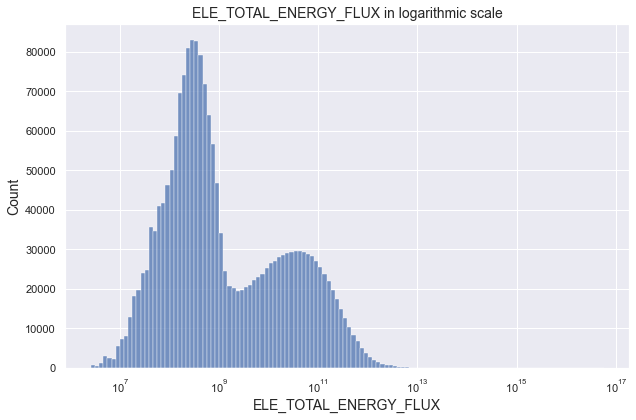

In [4]:
# Distribution of the target variable
plt.figure(figsize = (9, 6))
sns.histplot(data = data, x = 'ELE_TOTAL_ENERGY_FLUX', bins = math.floor(len(data)**(1/3)), log_scale = True)
plt.title("ELE_TOTAL_ENERGY_FLUX in logarithmic scale", fontsize = 14)
plt.xlabel("ELE_TOTAL_ENERGY_FLUX", fontsize = 14)
plt.ylabel("Count", fontsize = 14)
plt.tight_layout()
plt.show()

### Feature Extraction from Datetimes

In [5]:
# Creating new features from the Datetimes column
data['year'] = data['Datetimes'].apply(lambda x: float(x.split()[0].split('-')[0]))
data['month'] = data['Datetimes'].apply(lambda x: float(x.split()[0].split('-')[1]))
data['day'] = data['Datetimes'].apply(lambda x: float(x.split()[0].split('-')[2]))
data['hour'] = data['Datetimes'].apply(lambda x: float(x.split()[1].split(':')[0]))
data['minute'] = data['Datetimes'].apply(lambda x: float(x.split()[1].split(':')[1]))
data['second'] = data['Datetimes'].apply(lambda x: float(x.split()[1].split(':')[2]))

In [6]:
# Dropping the 'Datetimes' column
data.drop(['Datetimes'], axis = 1, inplace = True)

In [7]:
# Rearranging the columns
cols = data.columns.tolist()
cols = cols[-6:] + cols[:-6]
data = data[cols]

In [8]:
# Printing the new features
print(pd.Series({"Shape": "{}".format(data[['year', 'month', 'day', 'hour', 'minute', 'second']].shape)}).to_string())
print(" ")
data[['year', 'month', 'day', 'hour', 'minute', 'second']].head()

Shape    (1945887, 6)
 


,year,month,day,hour,minute,second
0,1987.0,1.0,12.0,12.0,57.0,0.0
1,1987.0,1.0,12.0,12.0,58.0,0.0
2,1987.0,1.0,12.0,13.0,1.0,0.0
3,1987.0,1.0,12.0,13.0,2.0,0.0
4,1987.0,1.0,12.0,13.0,3.0,0.0


In [9]:
# Statistical description of the new features
data[['year', 'month', 'day', 'hour', 'minute', 'second']].describe()

,year,month,day,hour,minute,second
count,1.945887e+06,1.945887e+06,1.945887e+06,1.945887e+06,1.945887e+06,1945887.0
mean,2.007305e+03,6.702125e+00,1.559879e+01,1.156180e+01,2.951057e+01,0.0
std,4.294833e+00,3.492994e+00,8.784524e+00,6.927197e+00,1.728076e+01,0.0
min,1.987000e+03,1.000000e+00,1.000000e+00,0.000000e+00,0.000000e+00,0.0
25%,2.004000e+03,4.000000e+00,8.000000e+00,6.000000e+00,1.500000e+01,0.0
50%,2.006000e+03,7.000000e+00,1.600000e+01,1.200000e+01,3.000000e+01,0.0
75%,2.011000e+03,1.000000e+01,2.300000e+01,1.800000e+01,4.400000e+01,0.0
max,2.014000e+03,1.200000e+01,3.100000e+01,2.300000e+01,5.900000e+01,0.0


In [10]:
# Dropping the constant 'second' column
data.drop(['second'], axis = 1, inplace = True)

In [11]:
# Log-transforming the target
data['ELE_TOTAL_ENERGY_FLUX_LOG'] = data['ELE_TOTAL_ENERGY_FLUX'].apply(lambda x: np.log(x))

In [12]:
# Dropping the original target
data.drop(['ELE_TOTAL_ENERGY_FLUX'], axis = 1, inplace = True)

### Train-Test Split

In [13]:
# Train-test split
X = data.drop('ELE_TOTAL_ENERGY_FLUX_LOG', axis = 1) # Independent variables
y = data['ELE_TOTAL_ENERGY_FLUX_LOG'] # Target variable (log-transformed)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, shuffle = True)

In [14]:
# Resetting index
X_train.reset_index(drop = True, inplace = True)
X_test.reset_index(drop = True, inplace = True)
y_train.reset_index(drop = True, inplace = True)
y_test.reset_index(drop = True, inplace = True)

In [15]:
# Training set features
print(pd.Series({"Shape": "{}".format(X_train.shape)}).to_string())
print(" ")
X_train.head()

Shape    (1556709, 157)
 


,year,month,day,hour,minute,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,2012.0,2.0,19.0,16.0,37.0,65.541165,5.794600,0.115192,7015.72800,0.139369,...,95.0,-61.0,34.0,-27.0,2.55,440.1,-439.4,1.68,27783.156341,6018.345910
1,2001.0,7.0,20.0,5.0,33.0,62.448826,2.837912,0.400000,44.00000,0.565685,...,80.0,-72.0,8.0,-8.0,-0.74,482.6,-480.5,0.72,20493.063831,5024.205695
2,2010.0,12.0,24.0,1.0,43.0,68.149912,7.416243,0.254464,41.43591,0.353995,...,34.0,-15.0,19.0,-2.0,-0.13,320.5,-319.9,1.30,15977.785290,1948.008009
3,2001.0,7.0,27.0,23.0,44.0,57.938776,7.381723,0.224027,39.54718,0.324933,...,119.0,-73.0,46.0,-17.0,-0.04,425.9,-425.4,1.06,11930.163642,1460.427610
4,2003.0,8.0,31.0,21.0,10.0,72.335547,9.665239,0.129352,5252.97300,0.154653,...,74.0,-41.0,33.0,-10.0,-1.08,399.0,-398.9,1.17,2008.373324,113.398304


In [16]:
# Test set features
print(pd.Series({"Shape": "{}".format(X_test.shape)}).to_string())
print(" ")
X_test.head()

Shape    (389178, 157)
 


,year,month,day,hour,minute,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,2003.0,1.0,11.0,12.0,25.0,62.942552,11.666497,0.184363,55.63563,0.282004,...,119.0,-25.0,94.0,-15.0,0.21,448.9,-447.6,1.25,9601.535417,3131.950824
1,2004.0,5.0,19.0,2.0,45.0,70.118847,15.521607,0.372404,36.57064,0.528498,...,58.0,-28.0,30.0,7.0,-0.75,337.6,-337.2,2.49,23642.285097,4039.095414
2,2007.0,3.0,1.0,9.0,51.0,57.595433,7.973940,0.494023,31.84838,0.698423,...,82.0,-37.0,45.0,-20.0,0.75,621.0,-619.3,2.01,5495.745251,118.361862
3,2004.0,9.0,22.0,15.0,36.0,60.312506,9.241411,0.166789,68.81676,0.247261,...,297.0,-212.0,85.0,-9.0,1.72,472.8,-470.3,3.07,34210.271365,3985.766829
4,2008.0,9.0,8.0,3.0,13.0,66.510266,22.928470,0.126870,1348.12300,0.198879,...,106.0,-65.0,41.0,-11.0,1.04,578.3,-577.1,1.60,54047.643981,6420.408465


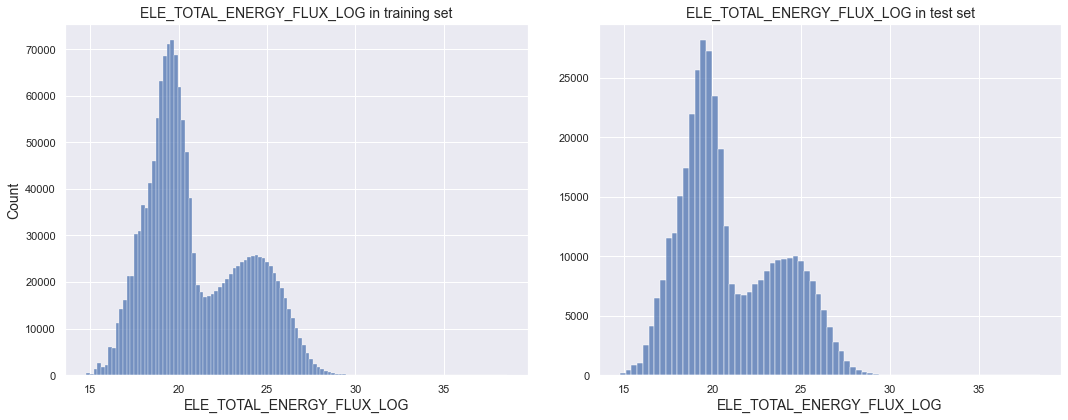

In [17]:
# Distribution of the target variable (in logarithmic scale) in the training set and test set
fig, ax = plt.subplots(1, 2, figsize = (15, 6), sharey = False)
sns.histplot(x = y_train, bins = math.floor(len(y_train)**(1/3)), ax = ax[0])
ax[0].set_title("ELE_TOTAL_ENERGY_FLUX_LOG in training set", fontsize = 14)
ax[0].set_xlabel("ELE_TOTAL_ENERGY_FLUX_LOG", fontsize = 14)
ax[0].set_ylabel("Count", fontsize = 14)
sns.histplot(x = y_test, bins = math.floor(len(y_test)**(1/3)), ax = ax[1])
ax[1].set_title("ELE_TOTAL_ENERGY_FLUX_LOG in test set", fontsize = 14)
ax[1].set_xlabel("ELE_TOTAL_ENERGY_FLUX_LOG", fontsize = 14)
ax[1].set_ylabel(" ", fontsize = 14)
plt.tight_layout()
plt.show()

In [18]:
# Min-max normalization of predictors in the training set
for col in X_train.columns:
    if X_train[col].dtypes == 'int64' or X_train[col].dtypes == 'float64': # Checking if the column is numerical
        if X_train[col].nunique() > 1: # Checking if the column is non-constant
            X_train[col] = (X_train[col] - X_train[col].min()) / (X_train[col].max() - X_train[col].min())

print(pd.Series({"Shape": "{}".format(X_train.shape)}).to_string())
print(" ")
X_train.head()

Shape    (1556709, 157)
 


,year,month,day,hour,minute,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,0.925926,0.090909,0.600000,0.695652,0.627119,0.456751,0.241441,0.007713,0.233091,0.006286,...,0.073810,0.904175,0.121154,0.457627,0.479894,0.332180,0.663848,0.036292,0.277894,0.668736
1,0.518519,0.545455,0.633333,0.217391,0.559322,0.387990,0.118245,0.040649,0.000467,0.041679,...,0.061905,0.893738,0.071154,0.538136,0.334512,0.393454,0.603936,0.015304,0.204977,0.558271
2,0.851852,1.000000,0.766667,0.043478,0.728814,0.514759,0.309010,0.023819,0.000382,0.024104,...,0.025397,0.947818,0.092308,0.563559,0.361467,0.159746,0.838047,0.027984,0.159814,0.216455
3,0.518519,0.545455,0.866667,1.000000,0.745763,0.287705,0.307572,0.020299,0.000319,0.021692,...,0.092857,0.892789,0.144231,0.500000,0.365444,0.311707,0.684257,0.022737,0.119329,0.162277
4,0.592593,0.636364,1.000000,0.913043,0.169492,0.607830,0.402719,0.009351,0.174273,0.007555,...,0.057143,0.923150,0.119231,0.529661,0.319487,0.272924,0.722886,0.025142,0.020088,0.012600


In [19]:
# Min-max normalization of predictors in the test set
for col in X_test.columns:
    if X_test[col].dtypes == 'int64' or X_test[col].dtypes == 'float64': # Checking if the column is numerical
        if X_test[col].nunique() > 1: # Checking if the column is non-constant
            X_test[col] = (X_test[col] - X_test[col].min()) / (X_test[col].max() - X_test[col].min())

print(pd.Series({"Shape": "{}".format(X_test.shape)}).to_string())
print(" ")
X_test.head()

Shape    (389178, 157)
 


,year,month,day,hour,minute,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,0.592593,0.000000,0.333333,0.521739,0.423729,0.398870,0.486101,0.015962,0.000855,0.019698,...,0.100782,0.938330,0.236538,0.528634,0.379199,0.357977,0.642622,0.026891,0.096037,0.348040
1,0.629630,0.363636,0.600000,0.086957,0.762712,0.558402,0.646734,0.040348,0.000219,0.042609,...,0.047785,0.935484,0.113462,0.625551,0.335021,0.191410,0.807842,0.054001,0.236476,0.448847
2,0.740741,0.181818,0.000000,0.391304,0.864407,0.280001,0.332242,0.056121,0.000062,0.058402,...,0.068636,0.926945,0.142308,0.506608,0.404050,0.615534,0.385663,0.043507,0.054970,0.013153
3,0.629630,0.727273,0.700000,0.652174,0.610169,0.340403,0.385054,0.013683,0.001295,0.016469,...,0.255430,0.760911,0.219231,0.555066,0.448688,0.393744,0.608650,0.066681,0.342180,0.442920
4,0.777778,0.727273,0.233333,0.130435,0.220339,0.478182,0.955358,0.008506,0.043981,0.011972,...,0.089487,0.900380,0.134615,0.546256,0.417395,0.551631,0.448818,0.034543,0.540599,0.713471


### Principle Component Analysis (PCA)

In [20]:
# PCA-fitting the training set
pca = PCA(n_components = 20)
pca.fit(X_train)

PCA(n_components=20)

In [21]:
# PCA summary
print(pd.Series({"Number of components": "{}".format(pca.n_components_),
                 "Explained variance ratio": "{:.4g}%".format(pca.explained_variance_ratio_.sum()*100)
                }).to_string())

Number of components            20
Explained variance ratio    88.35%


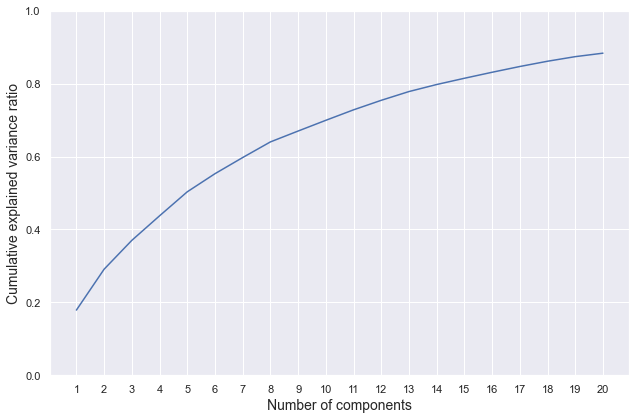

In [22]:
# Cumulative explained variance ratio
plt.figure(figsize = (9, 6))
sns.lineplot(x = np.arange(pca.n_components_) + 1, y = np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of components", fontsize = 14)
plt.xticks(np.arange(pca.n_components_) + 1)
plt.ylabel("Cumulative explained variance ratio", fontsize = 14)
plt.yticks(np.arange(0, 1.1, 0.2))
plt.tight_layout()
plt.show()

In [23]:
# Correlation structure of components and features
print(pd.Series({"Shape": "{}".format(pd.DataFrame(pca.components_, columns = X_train.columns).shape)}).to_string())
print(" ")
pd.DataFrame(pca.components_, columns = X_train.columns).head()

Shape    (20, 157)
 


,year,month,day,hour,minute,SC_AACGM_LAT,SC_AACGM_LTIME,ELE_TOTAL_ENERGY_FLUX_STD,ELE_AVG_ENERGY,ELE_AVG_ENERGY_STD,...,AE_5min,AL_5min,AU_5min,SymH_5min,PC_5min,vsw_5min,vx_5min,psw_5min,borovsky_5min,newell_5min
0,-0.038284,-0.029129,-0.012827,-0.000660,0.000967,-0.000739,-0.004206,-0.000635,0.009419,-0.000415,...,0.090989,-0.070067,0.078450,-0.031929,0.033986,0.091945,-0.092721,0.003571,0.125516,0.242298
1,-0.057351,-0.046220,0.013091,-0.023348,0.000546,0.000061,-0.020857,0.000441,0.005053,0.000915,...,-0.028259,0.022073,-0.023731,-0.015229,-0.021470,0.176995,-0.178570,0.001803,-0.076953,-0.191335
2,0.002353,0.009806,0.001207,0.243579,-0.001620,0.075157,0.470064,0.003927,-0.013041,0.004054,...,0.001177,-0.006701,-0.010730,0.000133,-0.000059,0.012064,-0.012146,0.000624,-0.004315,-0.005430
3,0.081903,-0.624013,-0.012380,-0.162705,0.000612,-0.032299,0.051752,0.003348,0.000274,0.002785,...,-0.015455,0.016643,-0.003720,0.005214,-0.002449,-0.009632,0.009530,0.000448,0.020328,0.012430
4,-0.021314,0.201761,0.009477,-0.536096,0.004490,-0.103706,0.158846,0.004127,0.001275,0.004223,...,-0.002755,0.014673,0.023065,-0.006141,-0.000718,-0.000306,0.000350,-0.000865,-0.006814,-0.002535


In [24]:
# PCA-transforming the training set features
X_train = pd.DataFrame(pca.transform(X_train))
print(pd.Series({"Shape": "{}".format(X_train.shape)}).to_string())
print(" ")
X_train.head()

Shape    (1556709, 20)
 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.813141,-0.230516,-0.305621,0.394485,-0.753807,-0.409744,0.207622,0.007863,0.116007,0.134160,-0.098359,-0.281156,-0.285079,0.043936,0.068696,-0.373895,-0.372899,0.055125,-0.013823,-0.149131
1,0.672915,0.283003,-0.595747,-0.057142,0.469043,0.122136,-0.271912,-0.103524,0.004053,0.066303,-0.390630,-0.364062,-0.320708,0.179590,0.180736,-0.221115,0.035227,-0.194456,-0.452795,-0.061986
2,-1.026166,-0.352974,-0.639334,-0.130190,0.294637,-0.588033,-0.231772,0.153528,0.194849,0.247871,-0.155301,0.222768,-0.013555,0.062666,0.049458,0.048924,0.100002,-0.061899,0.343089,0.081494
3,0.164096,0.216346,-0.334028,-0.396912,-0.362328,0.397118,-0.564873,0.288370,0.460966,0.272820,0.092630,0.004476,0.192266,-0.195802,0.181780,-0.054311,-0.009534,0.210342,-0.215392,-0.011616
4,-0.500978,0.384507,-0.074823,-0.602272,-0.473820,0.460664,-0.242567,0.596758,0.416705,-0.287698,-0.396371,0.304485,0.022351,-0.011560,0.344213,0.034684,0.148862,-0.200281,-0.094105,0.081579


In [25]:
# PCA transforming the test set features
X_test = pd.DataFrame(pca.transform(X_test))
print(pd.Series({"Shape": "{}".format(X_test.shape)}).to_string())
print(" ")
X_test.head()

Shape    (389178, 20)
 


,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19
0,0.242517,-0.043051,-0.066514,0.344063,-0.275106,-0.319389,0.653185,-0.191393,0.078492,-0.089905,0.331738,0.257866,-0.424640,-0.232644,-0.016398,-0.455679,-0.167912,0.264934,-0.254387,-0.025866
1,-0.577459,-0.384877,0.120156,0.548503,0.419949,0.130523,-0.511540,-0.351791,-0.072804,0.277625,-0.401590,0.482336,-0.251574,-0.019626,0.086654,-0.135887,0.406836,0.124094,0.089403,-0.040863
2,0.498763,1.631572,-0.474819,0.439382,-0.103074,0.150418,0.670990,0.373795,-0.502209,0.323510,0.236210,0.014579,0.209629,-0.174747,0.459645,-0.011700,-0.062305,-0.014229,-0.057278,0.036193
3,0.630488,0.367738,-0.154916,-0.771096,-0.376573,0.273419,0.267811,-0.132108,0.395024,0.120091,0.313758,0.062805,0.174999,-0.189026,0.821225,-0.062726,0.042545,0.469940,0.762419,-0.286800
4,1.307808,0.092126,0.220174,-0.169512,0.817157,-0.827458,-0.652841,-0.682285,-0.414495,-0.303358,-0.105563,-0.240131,0.161357,0.153211,-0.292141,-0.079069,-0.265036,-0.044505,-0.216782,-0.074953


### Baseline Model - Neural Network

In [26]:
# Adding layers to sequential model
model = Sequential()
model.add(Dense(units = 128, input_dim = len(X_train.columns), activation = 'relu'))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dense(units = 32, activation = 'relu'))
model.add(Dense(units = 16, activation = 'relu'))
model.add(Dense(units = 4, activation = 'relu'))
model.add(Dense(units = 1, activation = 'linear'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               2688      
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 16)                528       
                                                                 
 dense_4 (Dense)             (None, 4)                 68        
                                                                 
 dense_5 (Dense)             (None, 1)                 5         
                                                                 
Total params: 13,625
Trainable params: 13,625
Non-traina

In [27]:
# Specifying loss function and optimizer
adam_opt = Adam(learning_rate = 0.001,
                beta_1 = 0.9,
                beta_2 = 0.999,
                epsilon = 1e-07,
                amsgrad = False)
sgd_opt = SGD(learning_rate = 0.01, momentum = 0.9, nesterov = False)
model.compile(loss = 'mean_squared_error', optimizer = adam_opt)

In [28]:
%%time
# Fitting the model
history = model.fit(X_train, y_train, epochs = 120, batch_size = 32, validation_split = 0.2)

Epoch 1/120
38918/38918 [==============================] - 90s 2ms/step - loss: 4.5376 - val_loss: 2.7622
Epoch 2/120
38918/38918 [==============================] - 86s 2ms/step - loss: 2.7443 - val_loss: 2.6824
Epoch 3/120
38918/38918 [==============================] - 84s 2ms/step - loss: 2.6549 - val_loss: 2.5940
Epoch 4/120
38918/38918 [==============================] - 89s 2ms/step - loss: 2.6079 - val_loss: 2.5668
Epoch 5/120
38918/38918 [==============================] - 93s 2ms/step - loss: 2.5743 - val_loss: 2.6750
Epoch 6/120
38918/38918 [==============================] - 91s 2ms/step - loss: 2.5482 - val_loss: 2.5490
Epoch 7/120
38918/38918 [==============================] - 91s 2ms/step - loss: 2.5292 - val_loss: 2.5520
Epoch 8/120
38918/38918 [==============================] - 90s 2ms/step - loss: 2.5085 - val_loss: 2.5013
Epoch 9/120
38918/38918 [==============================] - 75s 2ms/step - loss: 2.4948 - val_loss: 2.4823
Epoch 10/120
38918/38918 [====================

38918/38918 [==============================] - 46s 1ms/step - loss: 2.3133 - val_loss: 2.3657
Epoch 78/120
38918/38918 [==============================] - 45s 1ms/step - loss: 2.3136 - val_loss: 2.3578
Epoch 79/120
38918/38918 [==============================] - 44s 1ms/step - loss: 2.3138 - val_loss: 2.3496
Epoch 80/120
38918/38918 [==============================] - 45s 1ms/step - loss: 2.3127 - val_loss: 2.3639
Epoch 81/120
38918/38918 [==============================] - 43s 1ms/step - loss: 2.3124 - val_loss: 2.3571
Epoch 82/120
38918/38918 [==============================] - 45s 1ms/step - loss: 2.3118 - val_loss: 2.3918
Epoch 83/120
38918/38918 [==============================] - 43s 1ms/step - loss: 2.3110 - val_loss: 2.3627
Epoch 84/120
38918/38918 [==============================] - 42s 1ms/step - loss: 2.3112 - val_loss: 2.3562
Epoch 85/120
38918/38918 [==============================] - 42s 1ms/step - loss: 2.3107 - val_loss: 2.3591
Epoch 86/120
38918/38918 [========================

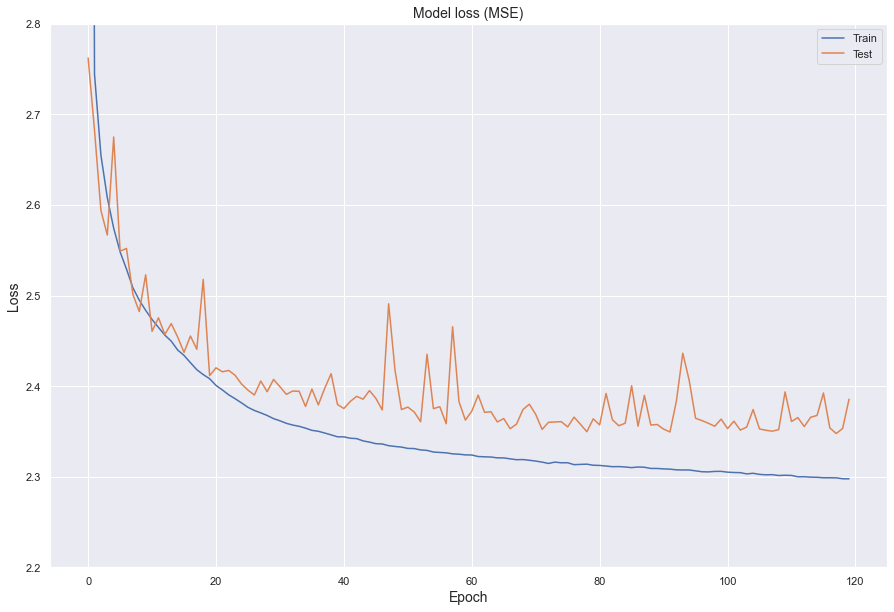

In [29]:
# Visualization of model loss
plt.figure(figsize = (15, 10))
plt.title('Model loss (MSE)', fontsize = 14)
sns.lineplot(data = history.history['loss'], label = 'Train')
sns.lineplot(data = history.history['val_loss'], label = 'Test')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.ylim(2.2, 2.8)
plt.legend()
plt.savefig('mse.jpg')
plt.show()

In [30]:
# Prediction on the training set and the test set
y_train_pred = model.predict(X_train).flatten()
y_test_pred = model.predict(X_test).flatten()

12162/12162 [==============================] - 7s 583us/step


In [31]:
# Function to plot the error distribution
def error_dist(y_true, y_pred, figsize = (9, 6)):
    if len(y_true) != len(y_pred):
        raise Exception("The number of true values and the number of predicted values do not match.")
    else:
        plt.figure(figsize = figsize)
        sns.histplot(x = y_true - y_pred, bins = math.floor(len(y_true)**(1/3)))
        plt.title("Error distribution")
        plt.xlabel("error")
        plt.ylabel("Count")
        plt.tight_layout()
        plt.show()

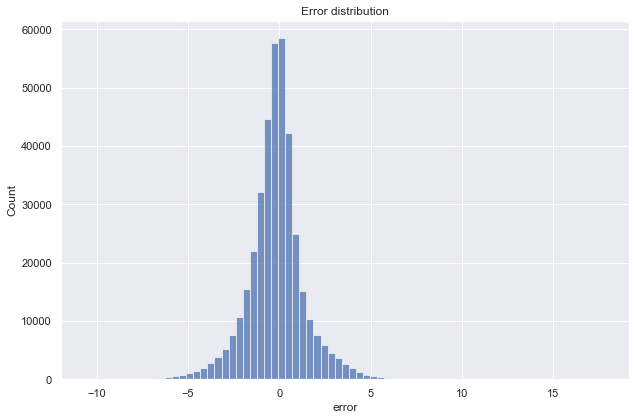

In [32]:
# Error distribution
error_dist(y_test, y_test_pred)

In [33]:
# Function to compute dataframe of evaluation metrics
def eval_df(y_train, y_train_pred, y_test, y_test_pred):
    eval_dict_train = pd.Series({'RMSE': np.sqrt(mean_squared_error(y_train, y_train_pred)),
                                 'MAE': mean_absolute_error(y_train, y_train_pred),
                                 'R2': r2_score(y_train, y_train_pred)})
    eval_dict_test = pd.Series({'RMSE': np.sqrt(mean_squared_error(y_test, y_test_pred)),
                                'MAE': mean_absolute_error(y_test, y_test_pred),
                                'R2': r2_score(y_test, y_test_pred)})
    eval_df_train = pd.DataFrame(eval_dict_train.items(), columns = ['Metric', 'Train'])
    eval_df_train.set_index('Metric', inplace = True)
    eval_df_test = pd.DataFrame(eval_dict_test.items(), columns = ['Metric', 'Test'])
    eval_df_test.set_index('Metric', inplace = True)
    eval_df_concat = pd.concat([eval_df_train, eval_df_test], axis = 1, sort = False).reset_index()
    eval_df_concat.rename(columns = {'index': 'Metric'})
    return eval_df_concat

In [34]:
# Evaluation metrics
display(eval_df(y_train, y_train_pred, y_test, y_test_pred))

,Metric,Train,Test
0,RMSE,1.524358,1.545271
1,MAE,1.076710,1.090734
2,R2,0.703832,0.694745


### Hyperparameter Tuning

In [35]:
# Building the model
def model_builder(hp):
    model = Sequential()
    model.add(Flatten(input_shape = (X_train.shape[1],)))

    # Tuning the number of units in the Dense layers
    hp_units = hp.Int('units', min_value = 128, max_value = 512, step = 128)
    
    # Adding layers to sequential model
    model.add(Dense(units = hp_units, activation = 'relu'))
    model.add(Dense(units = 64, activation = 'relu'))
    model.add(Dense(units = 32, activation = 'relu'))
    model.add(Dense(units = 16, activation = 'relu'))
    model.add(Dense(units = 4, activation = 'relu'))
    model.add(Dense(units = 1, activation = 'linear'))

    # Tuning the learning rate for the optimizer
    hp_learning_rate = hp.Choice('learning_rate', values = [0.01, 0.001, 0.0001])
    
    # Model compilation
    model.compile(loss = 'mean_squared_error', optimizer = Adam(learning_rate = hp_learning_rate))

    return model

In [36]:
# Instantiate the tuner
tuner = kt.Hyperband(model_builder, objective = 'val_loss', max_epochs = 120, factor = 2, directory = 'dir_1')

In [37]:
# Tuning settings
tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 128, 'max_value': 512, 'step': 128, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [38]:
# Searching for optimal hyperparameters
tuner.search(X_train, y_train, epochs = 120, validation_split = 0.2)
hp_tuned = tuner.get_best_hyperparameters()[0]

Trial 12 Complete [00h 02m 33s]
val_loss: 2.6926071643829346

Best val_loss So Far: 2.6209185123443604
Total elapsed time: 00h 23m 18s


In [39]:
# Building the model with optimal hyperparameters
model_tuned = tuner.hypermodel.build(hp_tuned)
model_tuned.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 20)                0         
                                                                 
 dense_6 (Dense)             (None, 256)               5376      
                                                                 
 dense_7 (Dense)             (None, 64)                16448     
                                                                 
 dense_8 (Dense)             (None, 32)                2080      
                                                                 
 dense_9 (Dense)             (None, 16)                528       
                                                                 
 dense_10 (Dense)            (None, 4)                 68        
                                                                 
 dense_11 (Dense)            (None, 1)                

In [40]:
# Model fitting
history_tuned = model_tuned.fit(X_train, y_train, epochs = 120, validation_split = 0.2)

Epoch 1/120
38918/38918 [==============================] - 54s 1ms/step - loss: 3.6471 - val_loss: 2.6966
Epoch 2/120
38918/38918 [==============================] - 54s 1ms/step - loss: 2.7002 - val_loss: 2.6098
Epoch 3/120
38918/38918 [==============================] - 53s 1ms/step - loss: 2.6046 - val_loss: 2.6007
Epoch 4/120
38918/38918 [==============================] - 54s 1ms/step - loss: 2.5498 - val_loss: 2.5044
Epoch 5/120
38918/38918 [==============================] - 52s 1ms/step - loss: 2.5120 - val_loss: 2.5694
Epoch 6/120
38918/38918 [==============================] - 49s 1ms/step - loss: 2.4841 - val_loss: 2.5156
Epoch 7/120
38918/38918 [==============================] - 49s 1ms/step - loss: 2.4604 - val_loss: 2.5052
Epoch 8/120
38918/38918 [==============================] - 48s 1ms/step - loss: 2.4406 - val_loss: 2.4565
Epoch 9/120
38918/38918 [==============================] - 48s 1ms/step - loss: 2.4250 - val_loss: 2.5016
Epoch 10/120
38918/38918 [====================

38918/38918 [==============================] - 47s 1ms/step - loss: 2.2661 - val_loss: 2.3412
Epoch 78/120
38918/38918 [==============================] - 47s 1ms/step - loss: 2.2656 - val_loss: 2.3427
Epoch 79/120
38918/38918 [==============================] - 48s 1ms/step - loss: 2.2664 - val_loss: 2.3399
Epoch 80/120
38918/38918 [==============================] - 48s 1ms/step - loss: 2.2654 - val_loss: 2.3452
Epoch 81/120
38918/38918 [==============================] - 48s 1ms/step - loss: 2.2655 - val_loss: 2.3427
Epoch 82/120
38918/38918 [==============================] - 47s 1ms/step - loss: 2.2648 - val_loss: 2.3611
Epoch 83/120
38918/38918 [==============================] - 47s 1ms/step - loss: 2.2637 - val_loss: 2.3508
Epoch 84/120
38918/38918 [==============================] - 47s 1ms/step - loss: 2.2636 - val_loss: 2.3413
Epoch 85/120
38918/38918 [==============================] - 48s 1ms/step - loss: 2.2630 - val_loss: 2.3472
Epoch 86/120
38918/38918 [========================

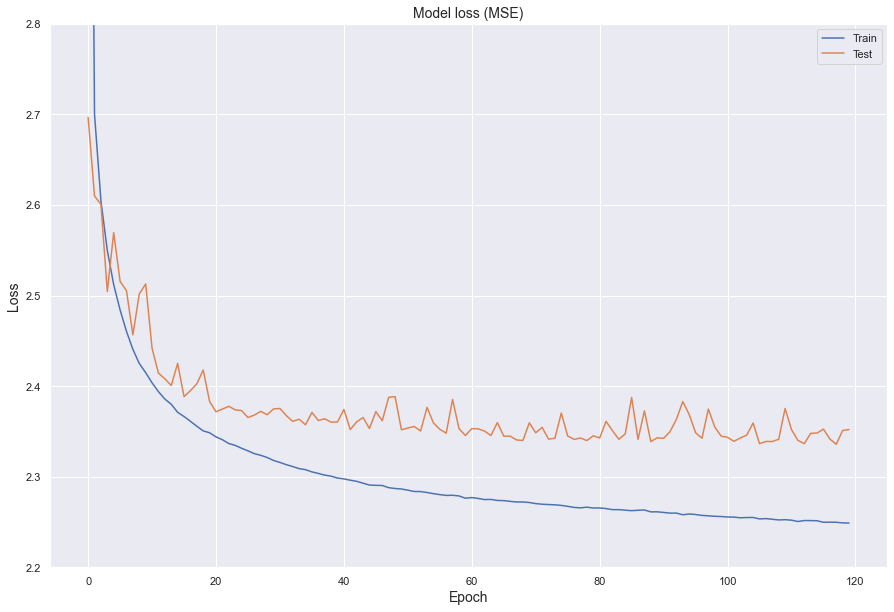

In [41]:
# Visualization of model loss
plt.figure(figsize = (15, 10))
plt.title('Model loss (MSE)', fontsize = 14)
sns.lineplot(data = history_tuned.history['loss'], label = 'Train')
sns.lineplot(data = history_tuned.history['val_loss'], label = 'Test')
plt.xlabel('Epoch', fontsize = 14)
plt.ylabel('Loss', fontsize = 14)
plt.ylim(2.2, 2.8)
plt.legend()
plt.savefig('mse_tuned.jpg')
plt.show()

In [42]:
# Prediction on the training set and the test set
y_train_pred_tuned = model_tuned.predict(X_train).flatten()
y_test_pred_tuned = model_tuned.predict(X_test).flatten()

12162/12162 [==============================] - 7s 565us/step


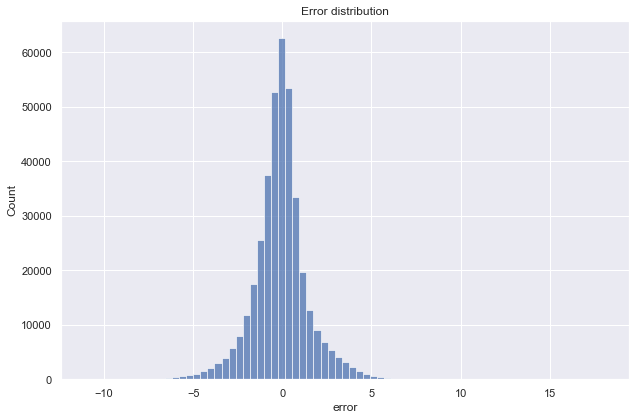

In [43]:
# Error distribution
error_dist(y_test, y_test_pred_tuned)

In [44]:
# Evaluation metrics
display(eval_df(y_train, y_train_pred_tuned, y_test, y_test_pred_tuned))

,Metric,Train,Test
0,RMSE,1.502412,1.534405
1,MAE,1.058467,1.079159
2,R2,0.712298,0.699023


### Explainable AI

In [45]:
# Loading JavaScript library
shap.initjs()

# Sampling from test data predictors
X_test_sample = X_test.sample(100)

# Predicted values corresponding to the sample
y_test_pred_tuned_sample = np.array(pd.Series(data = y_test_pred_tuned, index = X_test.index)[X_test_sample.index])

# Wrapper function
def wrap(X):
    return model_tuned.predict(X).flatten()

# Explainer
explainer = shap.KernelExplainer(wrap, X_test_sample)

# Computing SHAP values based on the sample
shap_values = explainer.shap_values(X_test_sample, nsamples = 500)

4/4 [==============================] - 0s 1ms/step


  0%|          | 0/100 [00:00<?, ?it/s]

1/1 [==============================] - 0s 16ms/step


1563/1563 [==============================] - 1s 615us/step


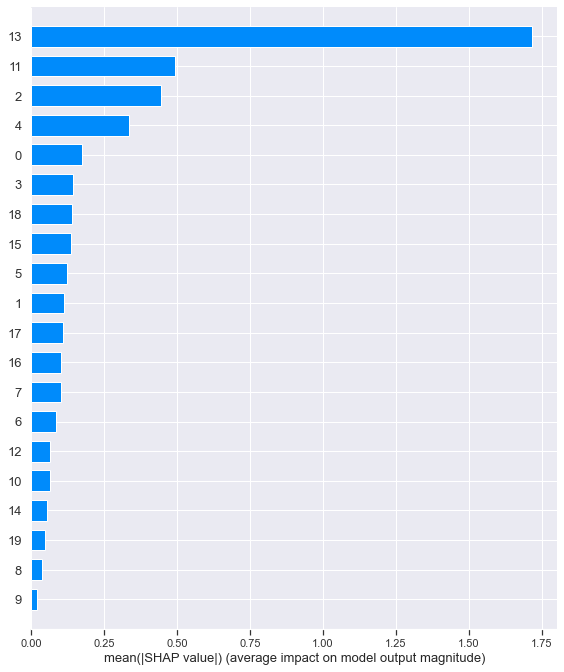

In [46]:
# Summary plot
shap.summary_plot(shap_values = shap_values, features = X_test_sample, plot_type = 'bar')

#### Explaining single prediction

In [47]:
# Force plot
shap.initjs()
row = math.floor(len(X_test_sample)/2)
print(pd.Series({"Predicted value": y_test_pred_tuned_sample[row]}).to_string())
shap_values_row = explainer.shap_values(X_test_sample.iloc[row, :], nsamples = 500)
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values_row,
                features = X_test_sample.iloc[row, :],
                feature_names = X_test_sample.columns)

Predicted value    19.096359
1563/1563 [==============================] - 1s 551us/step


Predicted value    19.096359


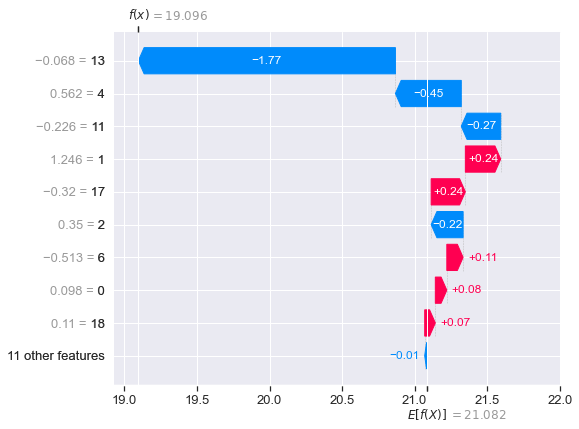

In [48]:
# Waterfall plot
print(pd.Series({"Predicted value": y_test_pred_tuned_sample[row]}).to_string())
shap.waterfall_plot(shap.Explanation(values = shap_values_row,
                                     base_values = explainer.expected_value,
                                     data = X_test_sample.iloc[row, :],
                                     feature_names = [str(x) for x in X_test_sample.columns.tolist()]))

Predicted value    19.096359


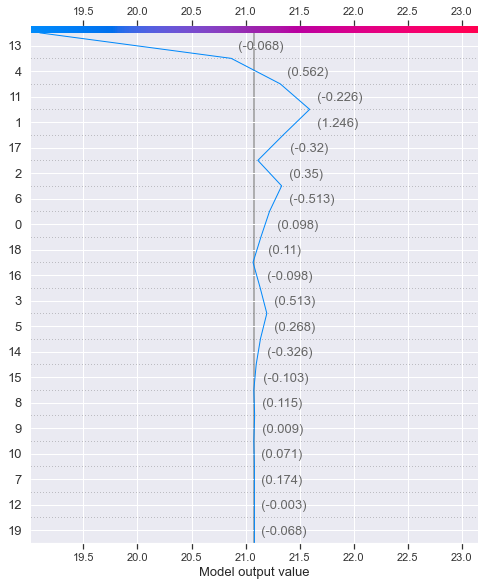

In [49]:
# Decision plot
print(pd.Series({"Predicted value": y_test_pred_tuned_sample[row]}).to_string())
shap.decision_plot(base_value = explainer.expected_value,
                   shap_values = shap_values_row,
                   features = X_test_sample.iloc[row, :],
                   feature_names = [str(x) for x in X_test_sample.columns.tolist()])

#### Explaining multiple predictions

In [50]:
# Force plot
shap.initjs()
shap.force_plot(base_value = explainer.expected_value,
                shap_values = shap_values,
                features = X_test_sample,
                feature_names = X_test_sample.columns)

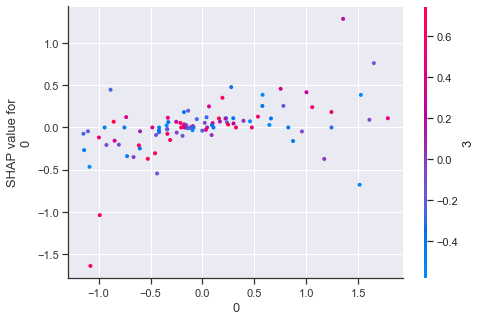

In [51]:
# Dependence plot for '0'
shap.dependence_plot(ind = 0, shap_values = shap_values, features = X_test_sample)

Predicted values
 
[23.220196 23.541601 17.50782  20.638285 20.218025 24.729645]
 


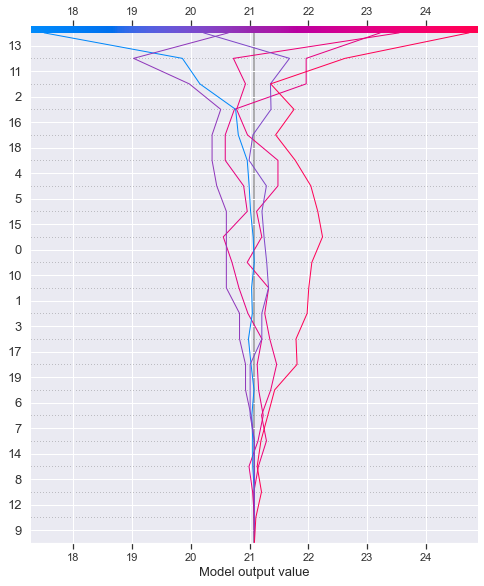

In [52]:
# Decision plot
print("Predicted values")
print(" ")
rows = [i*math.floor(len(X_test_sample)/6) for i in range(6)]
print(np.array(pd.Series(y_test_pred_tuned_sample)[rows]))
print(" ")
shap.decision_plot(base_value = explainer.expected_value, 
                   shap_values = shap_values[rows], 
                   features = X_test_sample.iloc[rows, :],
                   feature_names = [str(x) for x in X_test_sample.columns.tolist()])

In [53]:
# Runtime and memory usage
stop = time.time()
print(pd.Series({"Process runtime": "{:.2f} seconds".format(float(stop - start)),
                 "Process memory usage": "{:.2f} MB".format(float(process.memory_info()[0]/(1024*1024)))}).to_string())

Process runtime         14315.72 seconds
Process memory usage          4134.68 MB
